# 10-7. 번역기 만들기 (1) 데이터 전처리

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os

###### 해당 파일을 데이터프레임으로 읽어오기

In [2]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
150055,How long can a dead language survive?,Combien de temps une langue morte peut-elle vi...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
50196,I think nobody's home.,Je pense que personne n'est chez nous.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
128813,Have you ever been kissed before?,T'a-t-on jamais embrassé auparavant ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
128375,"Could I see you a minute, please?","Pourrais-je vous voir une minute, s'il vous pl...",CC-BY 2.0 (France) Attribution: tatoeba.org #3...
15742,That's a puzzle.,C'est une énigme.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


###### 세번째 열은 불필요하므로 제거하고, 훈련 데이터는 5만개의 샘플로 줄이자.

In [3]:
lines = lines[['eng', 'fra']][:50000]
lines.sample(5)

,eng,fra
25974,That's exactly it.,C'est exactement ça.
39969,Who won first prize?,Qui a gagné le premier prix ?
34523,Can you rub my back?,Peux-tu me masser le dos ?
11562,Please help us.,"Aide-nous, je te prie !"
14491,I talked to her.,Je lui ai parlé.


###### seq2seq 동작을 위해서 디코더의 입력과 예측에는 시작 토큰 <sos>와 종료 토큰 <eos>가 필요하다. 이번에는 각각 \t와 \n을 사용하겠다. 두 토큰을 추가해준다.

In [4]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines['fra'] = lines['fra'].apply(lambda x: '\t' + x + '\n')
print('전체 샘플의 수 : ', len(lines))
lines.sample(5)

전체 샘플의 수 :  50000


,eng,fra
46339,We need to cut costs.,\tNous devons sabrer dans les coûts.\n
46582,What are you holding?,\tQu'est-ce que tu tiens ?\n
15754,That's doubtful.,\tC'est douteux.\n
35470,How awesome is that?,\tC'est pas génial ça ?\n
3830,Surprise me.,\tSurprends-moi.\n


###### 이제 단어장(vocabulary)을 만들고, 각 단어에 부여된 고유한 정수로 텍스트 시퀀스를 정수 시퀀스로 변환하는 정수 인코딩 과정을 거치겠다. 이때 영어와 프랑스어는 사용하는 언어가 다르므로 단어장을 별도로 만들어준다. 그리고 정상적으로 정수 시퀀스로 변환되었는지 3개의 행을 출력해보자.

In [5]:
eng_tokenizer = Tokenizer(char_level=True) # 문자 단위로 Tokenizer를 생성
eng_tokenizer.fit_on_texts(lines['eng'])      # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines['eng'])
input_text[:3]

[[19, 3, 8], [19, 3, 8], [19, 3, 8]]

In [6]:
fra_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[10, 19, 5, 1, 31, 11],
 [10, 15, 5, 12, 16, 29, 2, 14, 11],
 [10, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 11]]

###### 단어장 크기를 변수로 저장 / 0번 토큰을 고려해서 +1

In [7]:
eng_vocab_size = len(eng_tokenizer.word_index)+1
fra_vocab_size = len(fra_tokenizer.word_index)+1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 53
프랑스어 단어장의 크기 : 73


###### 영어 데이터와 프랑스어 데이터의 최대 길이를 구해보자 -> 이는 패딩(pad)을 위함이다 / 모델에 입력될 영어, 프랑스어 시퀸스의 길이가 일정해야 하므로, 최대 길이로 맞추고 남은  시퀸스 뒷부분을 패딩으로 채우게 된다.

In [8]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 22
프랑스어 시퀀스의 최대 길이 74


###### 전체적인 통계 정보를 한꺼번에 출력

In [9]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 50000
영어 단어장의 크기 : 53
프랑스어 단어장의 크기 : 73
영어 시퀀스의 최대 길이 22
프랑스어 시퀀스의 최대 길이 74


###### 인코더의 입력으로 사용되는 영어 시퀸스와 달리, 프랑스어 시퀸스는 2가지 버전으로 나누어 준비해야 한다. 하나는 디코더의 출력과 비교해야 할 정답 데이터로 / 다른 하나는 이전 스텝에서 언급했던 교사 강요를 위해 디코더의 입력으로 사용하기 위한 것이다.
###### 이때, 디코더의 입력으로 사용할 시퀸스는  <eos>토큰이 필요가 없고, 디코더의 출력과 비교할 시퀸스는 <sos>가 필요없다. 
###### 영어로 'I am a person'이라는 문장을 프랑스어 'Je suis une personne'로 번역하는 번역기를 만든다고 해봅시다. 훈련 과정에서 디코더는 '< sos > Je suis une personne'를 입력받아서 'Je suis une personne < eos >'를 예측하도록 훈련되므로, 이런 방식으로 생성된 두가지 버전의 시퀀스를 준비해야 한다

In [10]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

###### 디코더의 입력과 출력을 각각 출력해봅시다.

In [11]:
print(decoder_input[:3])
print(decoder_target[:3])

[[10, 19, 5, 1, 31], [10, 15, 5, 12, 16, 29, 2, 14], [10, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31]]
[[19, 5, 1, 31, 11], [15, 5, 12, 16, 29, 2, 14, 11], [2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 11]]


###### 디코더의 입력의 경우에는 숫자 11 (<eos>토큰)이 제거되었고, 디코더의 출력의 경우에는 숫자 10(<sos>토큰)이 제거 되었다. 
###### 이제 패딩을 진행한다. 패딩을 진행하면 모든 샘플들의 길이가 정해준 길이로 동일하게 변환된다. 여기서는 아까 저장한 max_eng_seq_len, max_fra_seq_len를 사용할거다

In [12]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print("영어 데이터의 크기 : ", np.shape(encoder_input))
print("프랑스어 입력데이터의 크기 : ",np.shape(decoder_input))
print("프랑스어 출력데이터의 크기 : ", np.shape(decoder_target))

영어 데이터의 크기 :  (50000, 22)
프랑스어 입력데이터의 크기 :  (50000, 74)
프랑스어 출력데이터의 크기 :  (50000, 74)


###### 모든 샘플들의 길이가 동일하게 변환된 것을 알 수 있습니다. 모든 샘플들의 길이가 동일하게 변환되는 과정에서 정해준 길이보다 짧은 데이터들은 뒤에 0(<pad>)으로 채워집니다. 인코더의 샘플 하나만 출력해볼까요?

In [13]:
print(encoder_input[0])

[19  3  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


###### 앞서 [19, 3, 8]이라는 3개의 단어만 있단 샘플이 뒤에 0이 채워지면서 max_eng_seq_len의 값인 23의 길이를 가지게 되었다. 이제 각 정수에 대해서 벡터화 방법으로 원-핫 인코딩을 선택

In [14]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 22, 53)
프랑스어 입력데이터의 크기(shape) : (50000, 74, 73)
프랑스어 출력데이터의 크기(shape) : (50000, 74, 73)


###### 원-핫 인코딩을 하고나서의 데이터의 크기는 (샘플의 수 × 샘플의 길이 × 단어장의 크기)가 된다. 원-핫 인코딩은 각 정수를 단어장의 크기를 가지는 원-핫 벡터로 인코딩하는 과정이기 때문이다.

###### 마지막으로, 훈련과정의 validation을 위해 위에서 생성한 데이터 50000건 중 3000건만 검증데이터로 삼고, 나머지를 학습데이터로 삼겠다.

In [15]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

print('영어 테스트 데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 테스트 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 테스트 출력데이터의 크기(shape) :',np.shape(decoder_target_test))

영어 학습데이터의 크기(shape) : (47000, 22, 53)
프랑스어 학습 입력데이터의 크기(shape) : (47000, 74, 73)
프랑스어 학습 출력데이터의 크기(shape) : (47000, 74, 73)
영어 테스트 데이터의 크기(shape) : (3000, 22, 53)
프랑스어 테스트 입력데이터의 크기(shape) : (3000, 74, 73)
프랑스어 테스트 출력데이터의 크기(shape) : (3000, 74, 73)


# 10-7. 번역기 만들기 (2) 모델 훈련하기
###### 도구들 임포트

In [16]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

###### 먼저 인코더를 설계해볼까요? 인코더는 디코더보다 상대적으로 간단합니다. LSTM 셀을 설계하고나서 문장을 입력받으면 LSTM 셀이 마지막 time step의 hidden state와 cell state를 전달받아서 저장해줍니다. 앞서 인코더의 마지막 hidden state를 디코더의 첫번째 hidden state로 사용한다고 했었지요? 일반적인 기본 RNN의 경우에는 그것이 맞지만, 기본 RNN보다 좀 더 복잡한 LSTM의 경우에는 hidden state뿐만 아니라, cell sate라는 것이 존재합니다.

###### 그래서 인코더 LSTM 셀의 마지막 time step의 hidden state와 cell state를 디코더 LSTM의 첫번째 hidden state와 cell state로 전달해주어야 합니다

In [17]:
# 입력 텐서 생성.
encoder_inputs = Input(shape=(None, eng_vocab_size))
# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(units = 256, return_state = True)
# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

- 첫번째 줄 : 우선 LSTM의 입력 텐서를 정의해줍니다. 입력 문장을 저장하게 될 변수 텐서입니다.

- 두번째 줄 : 256의 hidden_size를 가지는 LSTM 셀을 만들어줍니다. LSTM의 수용력(capacity)를 의미합니다. return_state = True를 해서 hidden state와 cell state를 리턴받을 수 있도록 합니다.

- 세번째 줄 : 입력 텐서를 입력으로 마지막 time step의 hidden state와 cell state를 결과로 받습니다.

- 네번째 줄 : 마지막 time step의 hidden state와 cell state를 encoder_states라는 하나의 변수에 저장해뒀습니다. 이를 디코더에 전달하면 되겠네요.

###### 이제 디코더를 설계해볼까요? 디코더도 인코더랑 몇 가지 세부 사항을 제외하고 거의 똑같습니다.

In [18]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size))
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states)

###### 세번째 줄을 보면 디코더의 인자로 initial_state가 추가되었는데요. LSTM 셀의 초기 상태를 정의해줄 수 있는 인자입니다. 여기서는 이전에 저장한 인코더의 마지막 time step의 hidden state와 cell state를 사용하였습니다. 디코더의 출력층을 설계해줍니다.

In [19]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

###### 매 time step마다의 다중 클래스 분류 문제이므로 프랑스어 단어장으로부터 한 가지 문자만 선택하도록 합니다. Dense의 인자로 프랑스어 단어장의 크기를 기재하고, 활성화 함수로 소프트맥스 함수를 사용. 최종적으로 인코더와 디코더를 연결해서 하나의 모델로 만들어줍니다. Model의 Input과 Output의 정의를 유심히 살펴 주세요.

In [20]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 53)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 317440      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [21]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=10)

Epoch 1/10
368/368 [==============================] - 12s 21ms/step - loss: 0.8894 - val_loss: 0.7807
Epoch 2/10
368/368 [==============================] - 7s 18ms/step - loss: 0.5440 - val_loss: 0.6305
Epoch 3/10
368/368 [==============================] - 7s 18ms/step - loss: 0.4532 - val_loss: 0.5502
Epoch 4/10
368/368 [==============================] - 7s 18ms/step - loss: 0.3993 - val_loss: 0.5038
Epoch 5/10
368/368 [==============================] - 7s 18ms/step - loss: 0.3641 - val_loss: 0.4707
Epoch 6/10
368/368 [==============================] - 7s 18ms/step - loss: 0.3377 - val_loss: 0.4439
Epoch 7/10
368/368 [==============================] - 7s 18ms/step - loss: 0.3175 - val_loss: 0.4308
Epoch 8/10
368/368 [==============================] - 7s 18ms/step - loss: 0.3012 - val_loss: 0.4141
Epoch 9/10
368/368 [==============================] - 7s 18ms/step - loss: 0.2875 - val_loss: 0.4023
Epoch 10/10
368/368 [==============================] - 7s 18ms/step - loss: 0.2760 - val_l

# 

# 10-9. 번역기 만들기 (3) 모델 테스트하기
### 테스트 단계에서의 디코더의 동작 순서는 아래와 같습니다.
- 인코더에 입력 문장을 넣어 마지막 time step의 hidden, cell state를 얻는다.
- 토큰인 '\t'를 디코더에 입력한다.
- 이전 time step의 출력층의 예측 결과를 현재 time step의 입력으로 한다.
- 3을 반복하다가 토큰인 '\n'가 예측되면 이를 중단한다.
###### 이를 구현하기 위해서 훈련 과정에서와의 차이점은 이전 time step의 출력층의 예측 결과를 현재 time step의 입력으로 사용하는 단계를 추가하기 위해서 루프를 돌며 디코더의 LSTM 셀을 마치 수동 제어하는 느낌으로 설계해야 합니다. 코드가 좀 더 길어지게 되는데요.

###### 우선 인코더를 정의합니다. encoder_inputs와 encoder_states는 이미 정의한 것들을 재사용합니다.

In [22]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 53)]        0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 317440    
Total params: 317,440
Trainable params: 317,440
Non-trainable params: 0
_________________________________________________________________


###### 이제 디코더를 설계합니다.

In [23]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

###### 훈련 과정에서의 디코더보다 코드가 좀 더 길어졌죠? 이전 time step의 출력 결과를 현재 time step의 입력으로 사용하기 위해서 디코더 LSTM 셀의 동작을 좀 더 세분화해서 구현했습니다. 동작 자체는 이후에 구현할 def decode_sequence()에서 좀 더 자세히 다루겠습니다.

###### 디코더의 출력층을 재설계해줍니다.

In [24]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 input_3[0][0]              

###### 단어에서 정수로, 정수에서 단어로 바꾸는 사전(dictionary)을 준비해 둡니다. 테스트 결과를 해석하기 위해선 다시 사전이 필요하겠죠? 우리는 이전 스텝에서 문장을 숫자 인덱스로 바꾸는 Tokenizer를 만들면서 자동으로 만들어진 사전을 이미 가지고 있습니다.

In [25]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

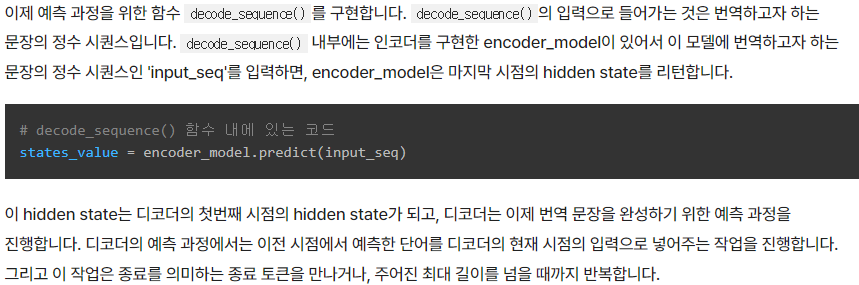

In [26]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, fra_vocab_size))
    target_seq[0, 0, fra2idx['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, fra_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

###### 이렇게 구현한 함수를 임의의 인덱스의 번역하고자하는 문장 샘플을 입력하여,

###### 출력 결과를 테스트해보겠습니다.

In [27]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Go.
정답 문장: Bouge !
번역기가 번역한 문장: va tout !
-----------------------------------
입력 문장: Hello!
정답 문장: Bonjour !
번역기가 번역한 문장: attendez.
-----------------------------------
입력 문장: Got it?
정답 문장: T'as capté ?
번역기가 번역한 문장: pour ça ?
-----------------------------------
입력 문장: Hang on.
정답 문장: Tiens bon !
번역기가 번역한 문장: sais de ma faute !
-----------------------------------
입력 문장: Here's $5.
정답 문장: Voilà cinq dollars.
번역기가 번역한 문장: voici !


###### 정확하진 않지만 비슷 문장이 나왔다고 한다... 난 잘 모르겠다
# 끝